In [1]:
import joblib
import os
# os.chdir('..')
os.listdir()

['mlp_architecture.py',
 'plots.ipynb',
 '__pycache__',
 'mlp_training_loop.py',
 'mlp_hyperparams.yaml',
 '.ipynb_checkpoints']

In [2]:

# trainingLoop = joblib.load('../mlp_training_loop_yes_weight_yes_norm_3.joblib')
trainingLoop = joblib.load('../mlp_training_loop_no_weight_yes_norm_3.joblib')
# trainingLoop = joblib.load('../mlp_training_loop_no_weight_no_norm.joblib')

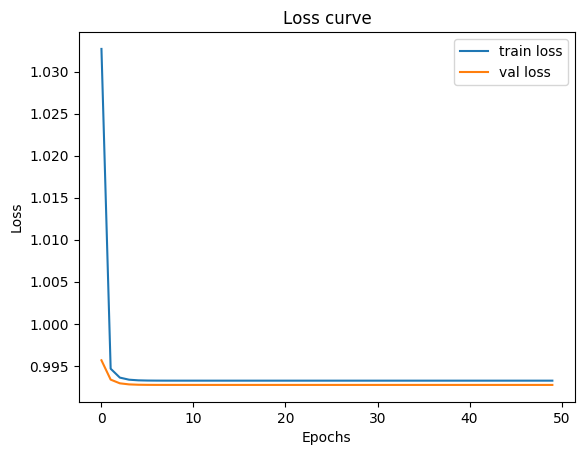

In [3]:
# x.plot_loss()
trainingLoop.plot_loss()

In [4]:
trainingLoop.train_acc

0.7504257832735187

In [5]:
from helpers.eval import stats
from helpers.preprocessing import read_all_data
from helpers import TrainingLoop

In [6]:
os.chdir('..')
import yaml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from mlp_architecture import MLPModel, MLPDataset

data_dict = read_all_data()
imu = data_dict['imu'].to_numpy()
ann = data_dict['ann'].to_numpy().flatten()
del data_dict # Remove to free memory

with open('MLP/mlp_hyperparams.yaml', 'r') as f:
    hyperparams = yaml.safe_load(f)
        
X_train, X_val, y_train, y_val = train_test_split(imu, ann, test_size=0.2, shuffle=False, random_state=42)
train_generator = DataLoader(MLPDataset(X_train, y_train), batch_size=hyperparams['batch_size'])
val_generator = DataLoader(MLPDataset(X_val, y_val), batch_size=hyperparams['batch_size'])

In [8]:
from tqdm import tqdm
import torch
# from torch import nncpu
from torch import nn
import torchmetrics as tm

def model_output_to_classes(model_output:torch.Tensor) -> torch.Tensor:
    print(model_output)
    return torch.max(model_output, 1)[1] # Indices of max values

def stats(model:nn.Module, dataloader:torch.utils.data.DataLoader,num_classes, device) -> float:
    precisions = []
    recalls = []
    f_ones = []
    f_ones1 = []
    f_ones2 = []
    f_ones3 = []
    f_ones4 = []
    precision = tm.Precision(task="multiclass", average='macro', num_classes=num_classes)
    recall = tm.Recall(task="multiclass", average='macro', num_classes=num_classes)
    f_one = tm.F1Score(task="multiclass", num_classes=num_classes)

    for (X, y) in tqdm(dataloader):
        # model.to('cpu')

        X = X.to('cuda')
        y = y.to('cpu')
        # print(X)
        # print(y)
        # print(model)
        model.eval()
        with torch.no_grad():
            y_p = model(X).to('cpu')
            
            #averages
            recalls.append((recall(y_p,y)).item())
            precisions.append((precision(y_p,y)).item())
            f_ones.append((f_one(y_p,y)).item())
            oney = y.clone()
            oneyp = y_p.clone()
            oney= oney[oney==0]
            oneyp= oneyp[oneyp==0]

            twoy = y.clone()
            twoyp = y_p.clone()
            twoy= twoy[twoy==0]
            twoyp= twoyp[twoyp==0]

            threey = y.clone()
            threeyp = y_p.clone()
            threey= threey[threey==0]
            threeyp= threeyp[threeyp==0]

            foury = y.clone()
            fouryp = y_p.clone()
            foury= foury[foury==0]
            fouryp= fouryp[fouryp==0]

            f_ones1.append((f_one(oneyp,oney)).item())
            f_ones2.append((f_one(twoyp,twoy)).item())
            f_ones3.append((f_one(threeyp,threey)).item())
            f_ones4.append((f_one(fouryp,foury)).item())
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f_ones)/len(f_ones), sum(f_ones1)/len(f_ones1),sum(f_ones2)/len(f_ones2),sum(f_ones3)/len(f_ones3),sum(f_ones4)/len(f_ones4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
stats(trainingLoop.model, trainingLoop.val_generator, num_classes=trainingLoop.hyperparams['num_classes'], device=device)

100%|██████████| 525/525 [00:02<00:00, 188.31it/s]


(0.18773371066365924, 0.25, 0.750934842654637)

In [10]:
trainingLoop.train_acc

0.7504257832735187